In [2]:
import numpy as np
import matplotlib.pyplot as plt, pandas as pd, matplotlib as mpl, random
def utkarshGrid(): plt.minorticks_on() ; plt.grid(color='grey',which='minor',linestyle=":",linewidth='0.1',) ; plt.grid(color='black',which='major',linestyle=":",linewidth='0.1',); return None
def utkarshGridAX(ax): ax.minorticks_on() ; ax.grid(color='grey',which='minor',linestyle=":",linewidth='0.1',) ; ax.grid(color='black',which='major',linestyle=":",linewidth='0.1',); return None
mpl.rcParams['legend.frameon'], mpl.rcParams['figure.autolayout'] = False, True,
colour = ["dodgerblue", "goldenrod", "crimson", "teal", "yellowgreen", "grey"]
plt.rcParams.update({"text.usetex": True, "font.family": "serif", "font.serif": ["Palatino"],})
def utkarshWrapper(): plt.legend();plt.utkarshGrid() ;plt.gca().tick_params(direction='in', which='both', right=True, top=True); plt.tight_layout(); return None
def utkarshWrapperAX(ax): utkarshGridAX(ax); ax.tick_params(direction='in', which='both', right=True, top=True); return None; 
plt.utkarshGrid = utkarshGrid; plt.utkarshWrapper = utkarshWrapper
def colour_sample(n = 2, col = colour, seed = 7236): random.seed(seed) ; return random.sample(colour, n)
plt.rcParams["image.cmap"] = "Set2" # I recommend, Set2, Dark2
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colour) # Use your own OR plt.cm.Set2.colors

In [3]:
import h5py
import matplotlib.pyplot as plt
import cosmology as cosmo
import corner
args = (70, 0.3, -1) # H0, Om0, w are the cosmological parameters
from scipy.stats import pearsonr
from scipy.stats import gaussian_kde

In [4]:
def read_df_style_normal(event_path):
    event = h5py.File(event_path, 'r')
    waveform = list(event.keys())[0]
    posterior_samples = event[waveform]["posterior_samples"]
    names = list(posterior_samples.dtype.names)
    df = pd.DataFrame([])
    for i in range(len(names)):
        name = names[i]
        df = pd.concat((df, pd.Series(posterior_samples[name]).rename(name)), axis=1)
    return df

def read_df_style_170817(event_path):
    event = h5py.File(event_path, 'r')
    waveform = list(event.keys())[0]
    names = event[waveform].dtype.names
    posterior_samples = event[waveform]
    df = pd.DataFrame([])
    for i in range(len(names)):
        name = names[i]
        df = pd.concat((df, pd.Series(posterior_samples[name]).rename(name)), axis=1)
        
    df["redshift"] = cosmo.redshift_func_jax(df["luminosity_distance_Mpc"].to_numpy(), 0, 1, args)
    df["mass_1_source"] = df["m1_detector_frame_Msun"]/(1+df["redshift"])
    df["mass_2_source"] = df["m2_detector_frame_Msun"]/(1+df["redshift"])
    df["mass_ratio"] = df["mass_2_source"]/df["mass_1_source"]
    df["chi_eff"] = (df["spin1"] * df["costilt1"] + df["mass_ratio"] * df["spin2"] * df["costilt2"]) / (1 + df["mass_ratio"])
    df["chirp_mass"] = (df["mass_1_source"] * df["mass_2_source"])**(3/5) / (df["mass_1_source"] + df["mass_2_source"])**(1/5)
    return df

In [5]:
def corner_plot(x, y, verbose = True):
    # convert to array
    x = np.array(x)
    y = np.array(y)
    
    if np.isnan(x).sum() > 0:
        if verbose:
            print("NaNs in x, cleaning up")
        y = y[~np.isnan(x)]
        x = x[~np.isnan(x)]
        
    if np.isnan(y).sum() > 0:
        if verbose:
            print("NaNs in y, cleaning up")
        x = x[~np.isnan(y)]
        y = y[~np.isnan(y)]
    
    # plot hist
    corner.hist2d(x, y)
    
    # calculate correlation
    r, p = pearsonr(x, y)
    if verbose:
        print(f"Correlation coefficient: {r:.3f}")
    return r, p

In [6]:
event_list = ["GW190425.h5", "GW170817.hdf5", "GW230529.h5", "GW200115.h5", "GW200105.h5", "GW190814.h5"]
data_path = "data/PE/"


names_list = [event.split(".")[0] for event in event_list]
GW190425 = read_df_style_normal(data_path + event_list[0])
GW170817 = read_df_style_170817(data_path + event_list[1])
GW230529 = read_df_style_normal(data_path + event_list[2])
GW200115 = read_df_style_normal(data_path + event_list[3])
GW200105 = read_df_style_normal(data_path + event_list[4])
GW190814 = read_df_style_normal(data_path + event_list[5])

# Create combined
combined_lst = [GW190425, GW170817, GW230529, GW200115, GW200105, GW190814]
combined = pd.concat(combined_lst, axis=0)

Theta_cut = (combined["mass_1_source"] < 3) & (combined["mass_2_source"] < 3)
Theta_cut_NSBH = None
BNS = combined[Theta_cut]
BBH = combined[~Theta_cut]

In [7]:
# Take mean of each even in combined_lst and collape into one lined dataframe

mean_df = pd.DataFrame([])

for i in range(len(combined_lst)):
    event = combined_lst[i]
    event_name = names_list[i]
    mean_df[event_name] = event.mean()
    # print names of rows in mean_df minus "recalib_"
    if i == 0:
        # print(list(mean_df.index))
        pass
    # keep all rows with row names "mass_1_source", "mass_2_source", "mass_ratio", "chi_eff", "chirp_mass"
    mean_df = mean_df.loc[["mass_1_source", "mass_2_source", "mass_ratio", "chi_eff", "chirp_mass", "a_1", "a_2", "spin_1x", "spin_1y", "spin_1z", "spin_2x", "spin_2y", "spin_2z"]]
    
    
mean_df

,GW190425,GW170817,GW230529,GW200115,GW200105,GW190814
mass_1_source,2.115370,1.616956,3.582439,6.626545,8.727875,23.315722
mass_2_source,1.333799,1.168756,1.484517,1.350858,1.989060,2.593856
mass_ratio,0.652638,0.737508,0.439402,0.212520,0.238290,0.111642
chi_eff,0.069809,0.022585,-0.111733,-0.056140,-0.024458,0.002901
chirp_mass,1.487382,1.186528,2.026044,2.582751,3.619632,6.417358
a_1,0.314319,NaN,0.446524,0.118186,0.109301,0.039868
a_2,0.350710,NaN,0.449393,0.126643,0.128870,0.481277
spin_1x,-0.017188,NaN,0.003960,0.000000,0.000000,-0.005924
spin_1y,-0.014439,NaN,0.003940,0.000000,0.000000,0.007626
spin_1z,0.077571,NaN,-0.142984,-0.068114,-0.033957,-0.002345


Scientific questions to ask: 

1. How strong is the correlation between mass ratio and Xeff, is it positive or negative? 
2. How strong is the correlation between m1 and Xeff, is it positive or negative?
3. How strong is the correlation between m2 and Xeff, is it positive or negative?
4. How strong is the correlation between chrip mass and Xeff, is it positive or negative?
5. How strong is the correlation between total mass and Xeff, is it positive or negative?
6. How strong is the correlation between chrip mass and mass ratio, is it positive or negative?

In [8]:
events_used = combined

Correlation coefficient: -0.795


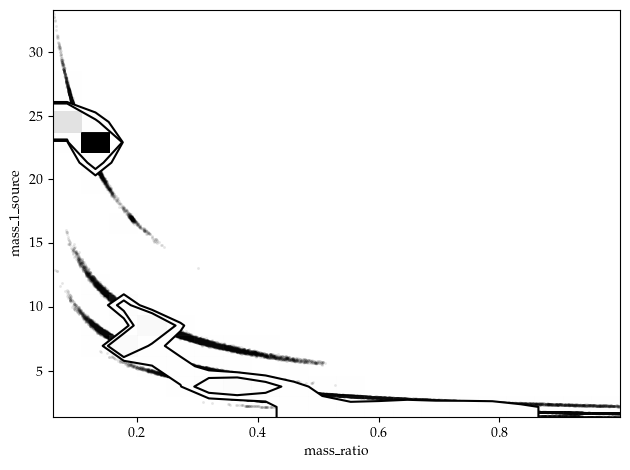

In [9]:
# How strong is the correlation between mass ratio and Xeff, is it positive or negative? 
plt.figure()
varX = "mass_ratio"
varY = "mass_1_source"
corner_plot(events_used[varX], events_used[varY])
plt.xlabel(varX)
plt.ylabel(varY)
plt.show()

Correlation coefficient: -0.180


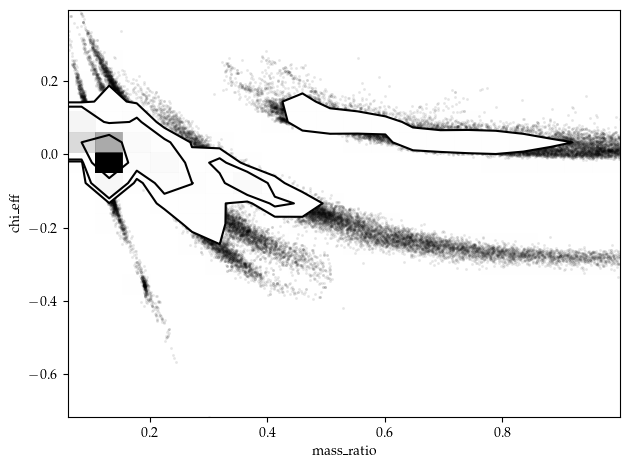

In [10]:
# How strong is the correlation between mass ratio and Xeff, is it positive or negative? 
plt.figure()
varX = "mass_ratio"
varY = "chi_eff"
corner_plot(events_used[varX], events_used[varY])
plt.xlabel(varX)
plt.ylabel(varY)
plt.show()

There is a strong anti-correlation between effective spin and mass ratio. 

Correlation coefficient: 0.226


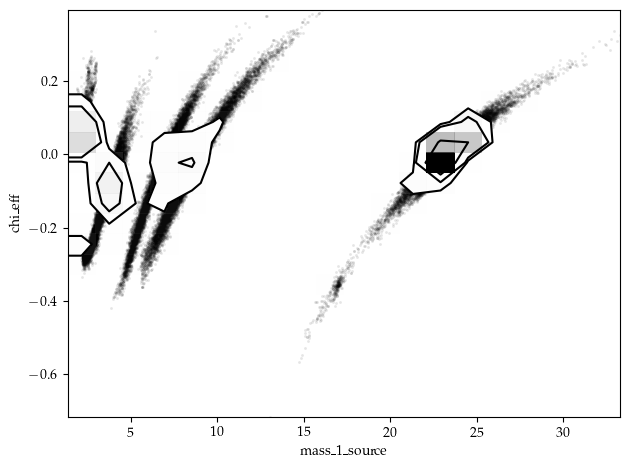

In [11]:
# How strong is the correlation between m1 and Xeff, is it positive or negative?
plt.figure()
varX = "mass_1_source"
varY = "chi_eff"
corner_plot(events_used[varX], events_used[varY])
plt.xlabel(varX)
plt.ylabel(varY)
plt.show()

There is a strong correlation between effective spin and source frame mass of the primary. 

Correlation coefficient: -0.066


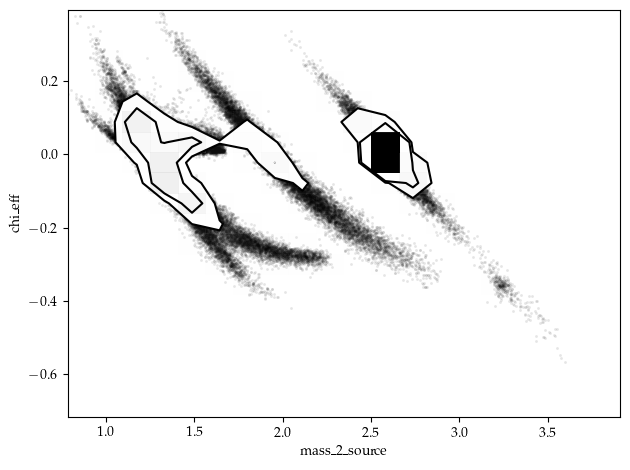

In [12]:
# How strong is the correlation between m2 and Xeff, is it positive or negative?
plt.figure()
varX = "mass_2_source"
varY = "chi_eff"
corner_plot(events_used[varX], events_used[varY])
plt.xlabel(varX)
plt.ylabel(varY)
plt.show()

There is a strong anti-correlation between effective spin and source frame mass of the secondary. 

Correlation coefficient: 0.902
Correlation coefficient: 0.831
Correlation coefficient: 0.054
Correlation coefficient: 0.875
Correlation coefficient: 0.861
Correlation coefficient: 0.880


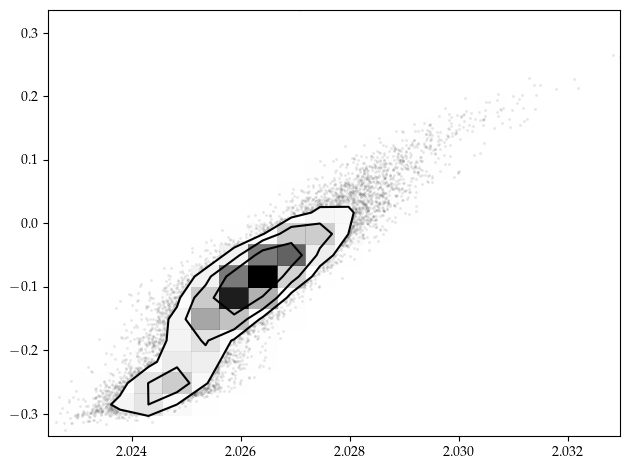

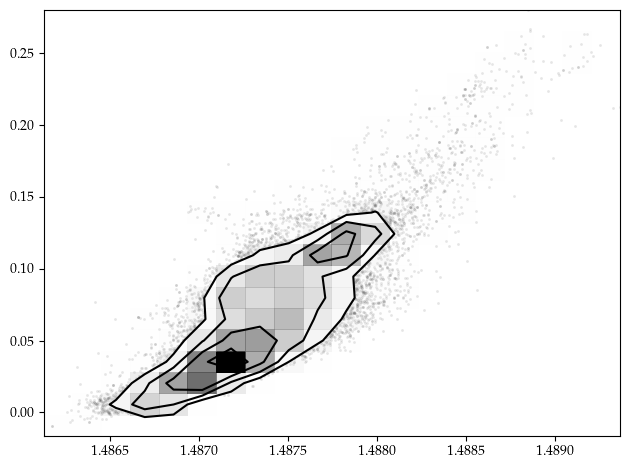

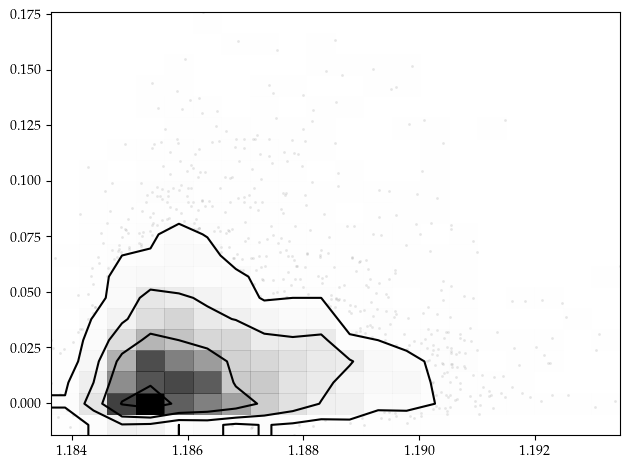

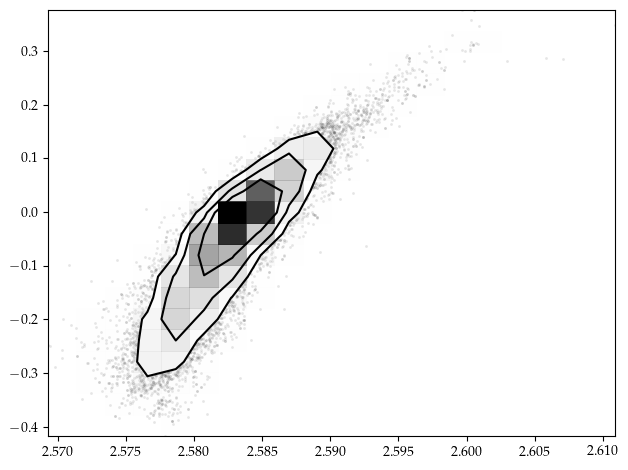

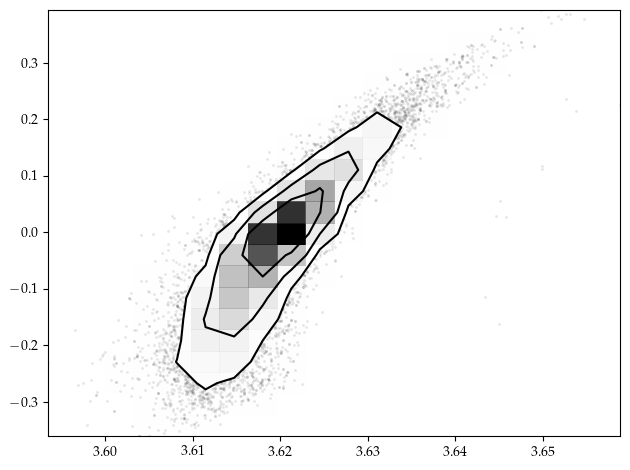

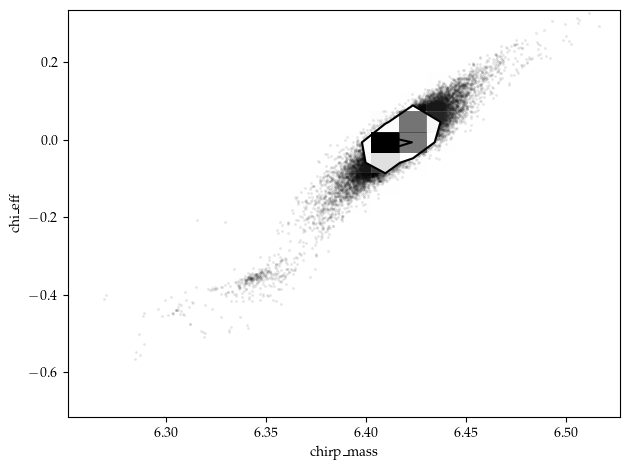

In [13]:
# How strong is the correlation between chrip mass and Xeff, is it positive or negative?
plt.figure()
varX = "chirp_mass"
varY = "chi_eff"
corner_plot(GW230529[varX], GW230529[varY])
plt.figure()
corner_plot(GW190425[varX], GW190425[varY])
plt.figure()
corner_plot(GW170817[varX], GW170817[varY])
plt.figure()
corner_plot(GW200115[varX], GW200115[varY])
plt.figure()
corner_plot(GW200105[varX], GW200105[varY])
plt.figure()
corner_plot(GW190814[varX], GW190814[varY])
plt.xlabel(varX)
plt.ylabel(varY)
plt.show()

Correlation coefficient: 0.902
Correlation coefficient: 0.831
Correlation coefficient: 0.054
Correlation coefficient: 0.875
Correlation coefficient: 0.861
Correlation coefficient: 0.880


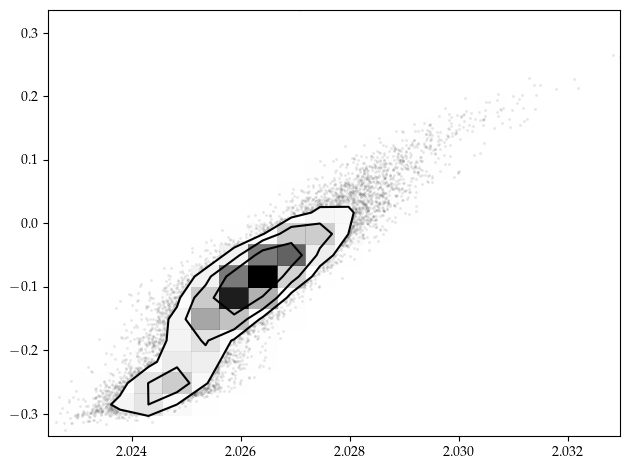

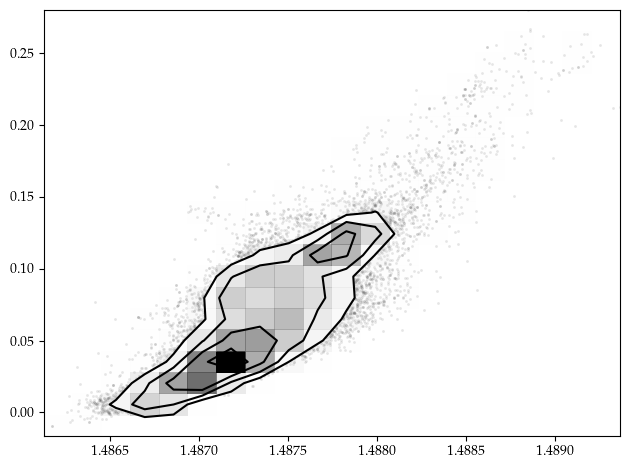

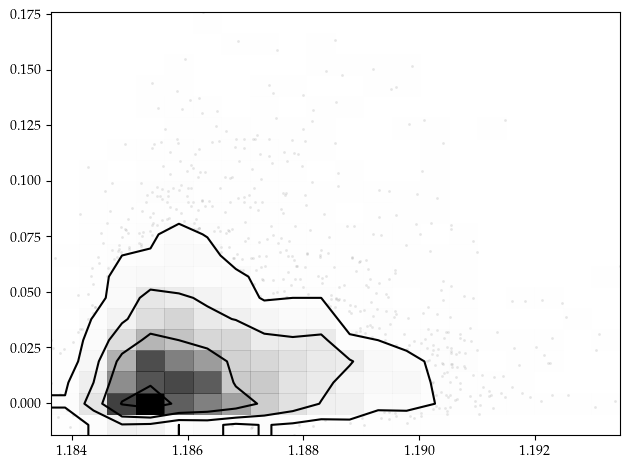

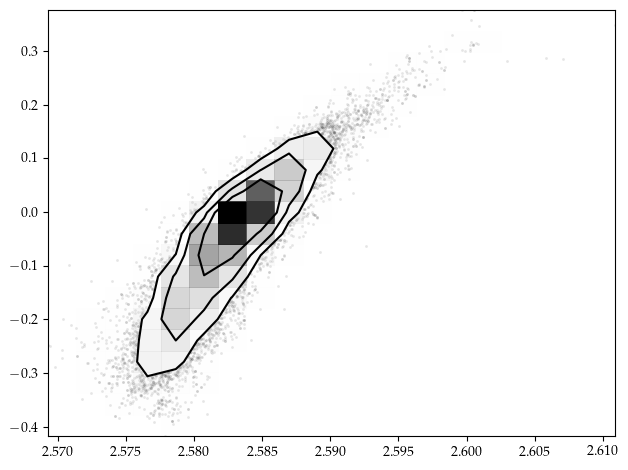

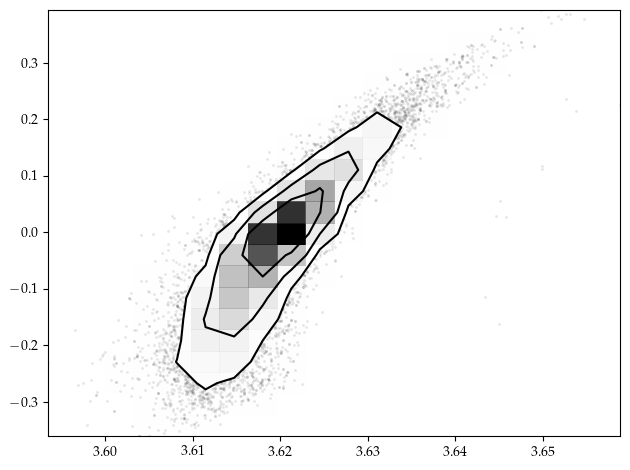

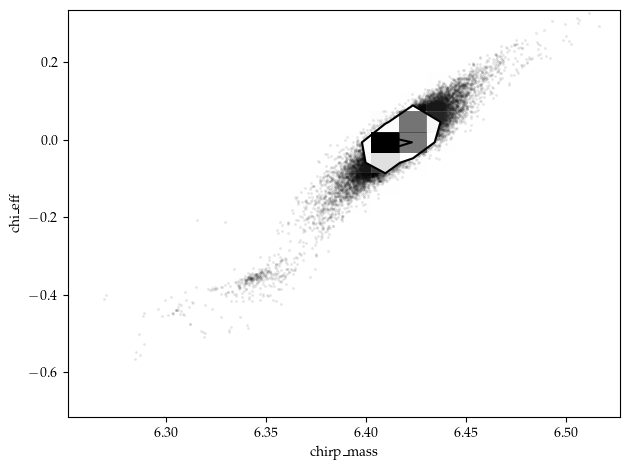

In [14]:
# How strong is the correlation between chrip mass and Xeff, is it positive or negative?
plt.figure()
varX = "chirp_mass"
varY = "chi_eff"
corner_plot(GW230529[varX], GW230529[varY])
plt.figure()
corner_plot(GW190425[varX], GW190425[varY])
plt.figure()
corner_plot(GW170817[varX], GW170817[varY])
plt.figure()
corner_plot(GW200115[varX], GW200115[varY])
plt.figure()
corner_plot(GW200105[varX], GW200105[varY])
plt.figure()
corner_plot(GW190814[varX], GW190814[varY])
plt.xlabel(varX)
plt.ylabel(varY)
plt.show()

There is strong correlation between chirp mass and effective spin for GW190425 and GW230529, but there is no correlation for GW170817. Upon further inspection, my guess is that in GW170817, there was no correlation between chirp mass and mass ratio, but there was such a (mild) correlation in GW190425, GW200115, GW200105 and GW230529. This correlation manifests itself as a correlation between effective spin and chirp mass in the plots above. 

Correlation coefficient: 0.949
Correlation coefficient: 0.849
Correlation coefficient: 0.948
Correlation coefficient: 0.970
Correlation coefficient: 0.968
Correlation coefficient: 0.949


<Figure size 640x480 with 0 Axes>

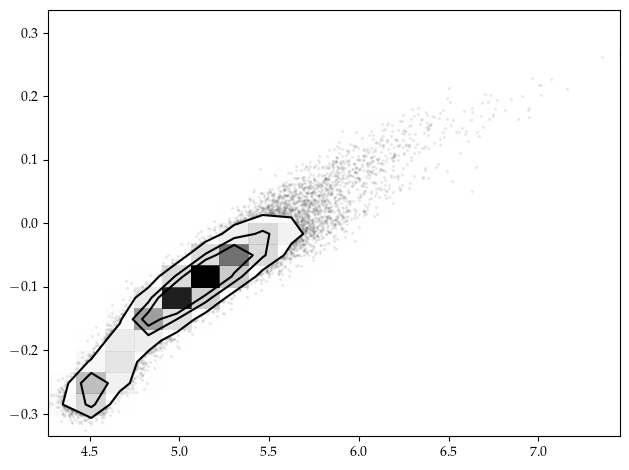

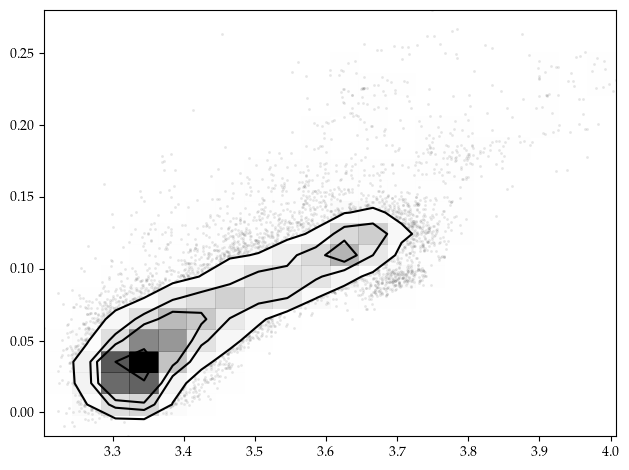

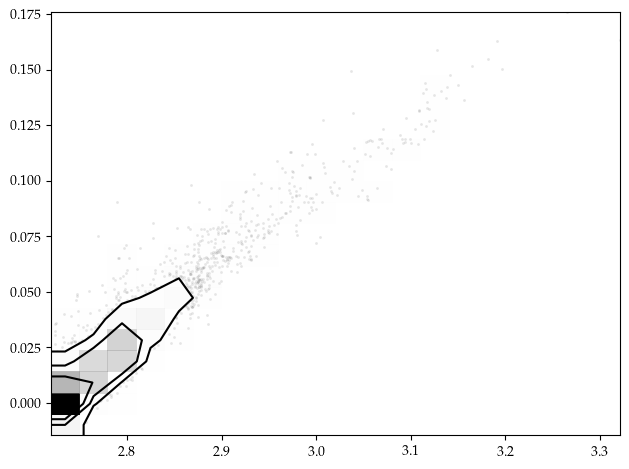

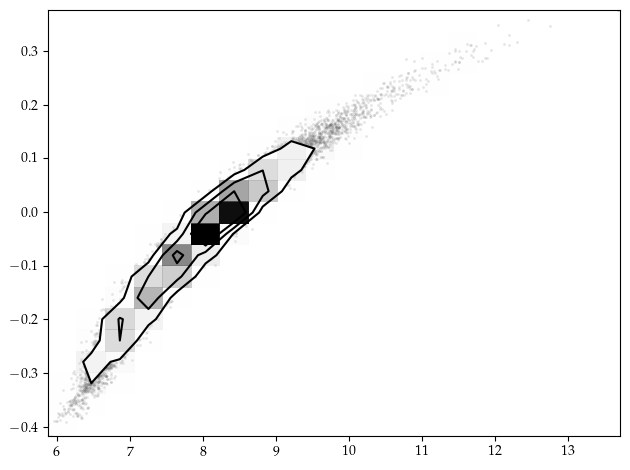

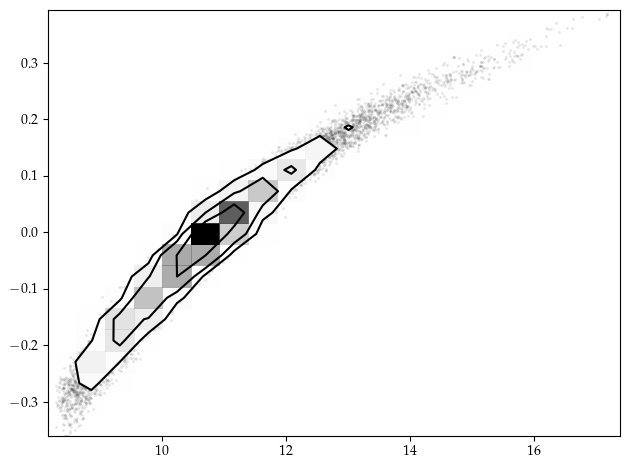

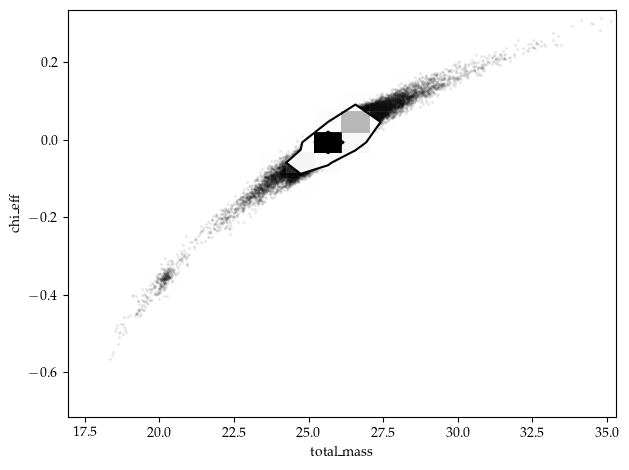

In [15]:
# How strong is the correlation between total mass and Xeff, is it positive or negative?
plt.figure()
varXa = "mass_1_source" 
varXb = "mass_2_source"
varX = "total_mass"
varY = "chi_eff"
plt.figure()
corner_plot(GW230529[varXa] + GW230529[varXb], GW230529[varY])
plt.figure()
corner_plot(GW190425[varXa] + GW190425[varXb], GW190425[varY])
plt.figure()
corner_plot(GW170817[varXa] + GW170817[varXb], GW170817[varY])
plt.figure()
corner_plot(GW200115[varXa] + GW200115[varXb], GW200115[varY])
plt.figure()
corner_plot(GW200105[varXa] + GW200105[varXb], GW200105[varY])
plt.figure()
corner_plot(GW190814[varXa] + GW190814[varXb], GW190814[varY])
plt.xlabel(varX)
plt.ylabel(varY)
plt.show()

There is a strong correlation between total mass and effective spin. The correlation strenghts are all approximately equal. The combined plot above shows up as an Occum factor. 

Correlation coefficient: -0.026
Correlation coefficient: -0.768
Correlation coefficient: -0.566
Correlation coefficient: -0.782
Correlation coefficient: -0.738
Correlation coefficient: -0.807


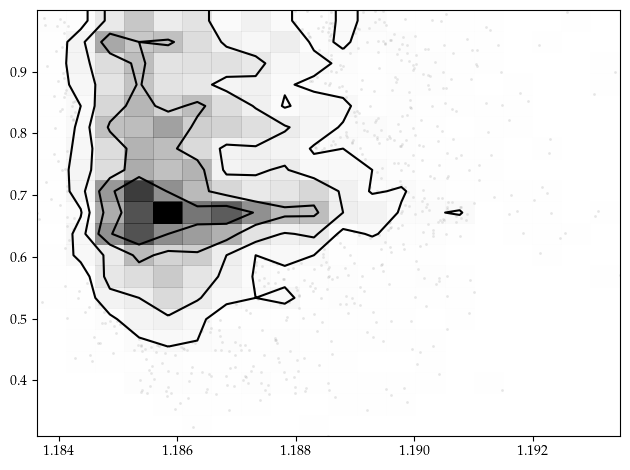

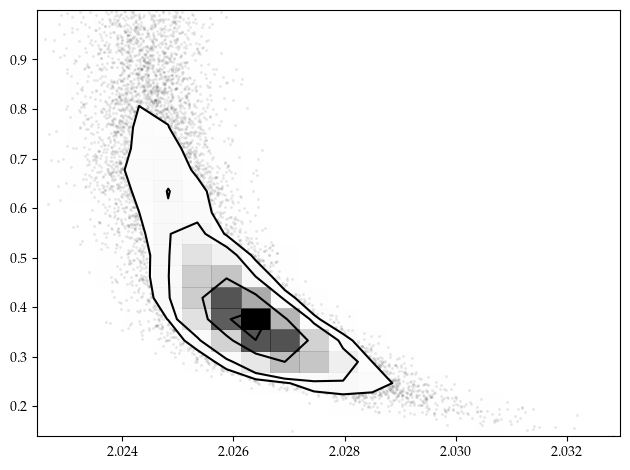

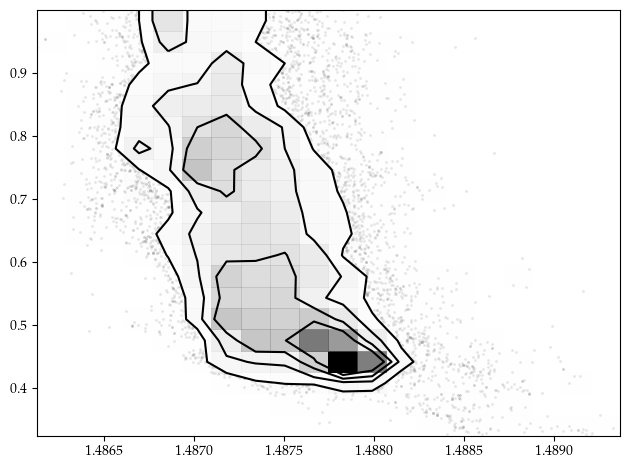

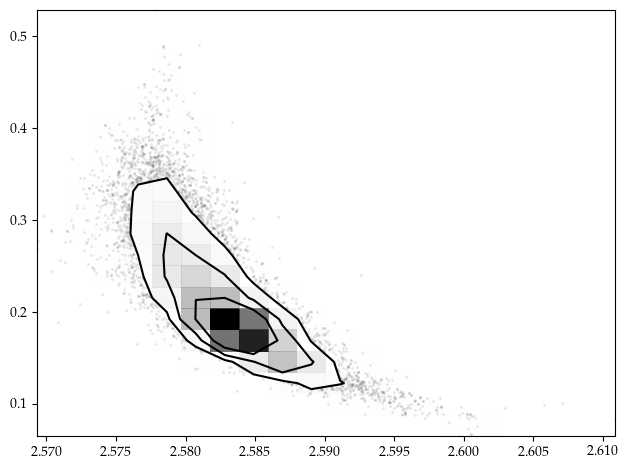

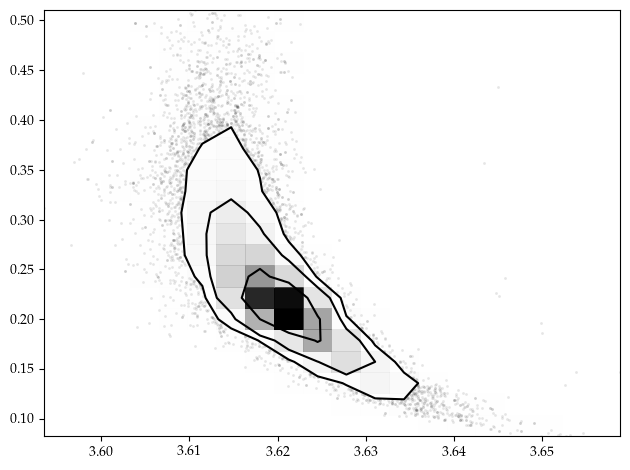

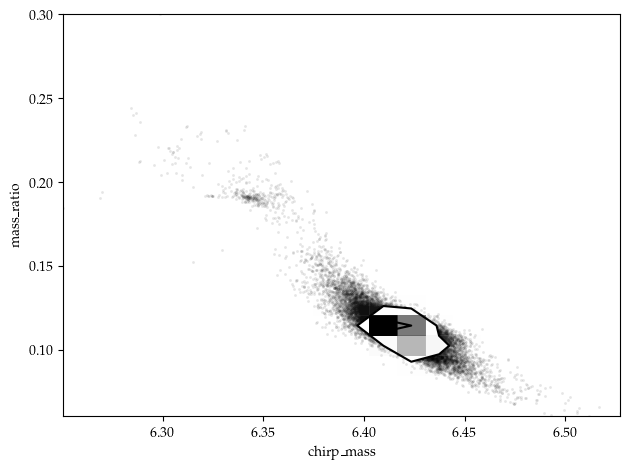

In [16]:
# How strong is the correlation between chrip mass and mass ratio, is it positive or negative?
plt.figure()
varX = "chirp_mass"
varY = "mass_ratio"
corner_plot(GW170817[varX], GW170817[varY])
plt.figure()
corner_plot(GW230529[varX], GW230529[varY])
plt.figure()
corner_plot(GW190425[varX], GW190425[varY])
plt.figure()
corner_plot(GW200115[varX], GW200115[varY])
plt.figure()
corner_plot(GW200105[varX], GW200105[varY])
plt.figure()
corner_plot(GW190814[varX], GW190814[varY])
plt.xlabel(varX)
plt.ylabel(varY)
plt.show()

There is a moderate anti-correlation between chirp mass and mass ratio for GW190425, GW200115, GW200105 and GW230529. This may explain why GW190425 and GW230529 have a correlation between chirp mass and effective spin.

Conclusions from questions asked above: 

In all events, there is a strong anti-correlation between effective spin and mass ratio. In all model, this manifests as a correlation with mass_1 and an anti-correlation with mass_2. In all events, total mass correlates with effective spin. For events GW190425 and GW230529, chirp mass correlates with mass ratio. For this reason correlations appear between chirp mass and effective spin.

New Questions: 
1. What does p(xeff) look like? What does the distribution of xeff look like for each event?
2. Does the shape of the m1, m2 vs xeff distribution change between events? 
3. Does p(x1) look different than p(x2) 

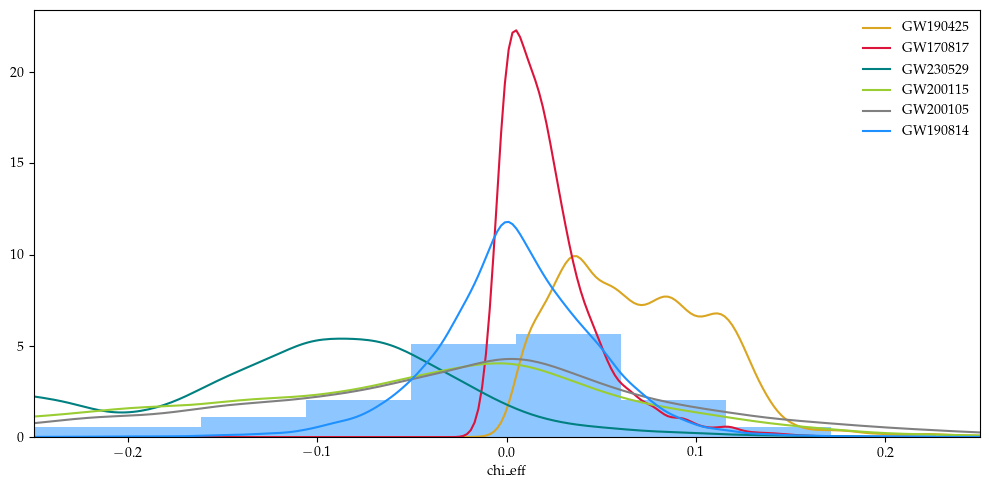

In [17]:
# What does p(xeff) look like? What does the distribution of xeff look like for each event?
plt.figure(figsize=(10, 5))
plt.hist(combined["chi_eff"], bins=20, alpha=0.5, density=True)

x = np.linspace(-1, 1, 1000)
# kde plot

for i in range(len(combined_lst)):
    kde = gaussian_kde(combined_lst[i]["chi_eff"])
    plt.plot(x, kde(x), label = names_list[i])

plt.xlim(-0.25, 0.25)
plt.xlabel("chi_eff")
plt.legend()
plt.show()

Correlation coefficient: -0.979
Correlation coefficient: 0.996


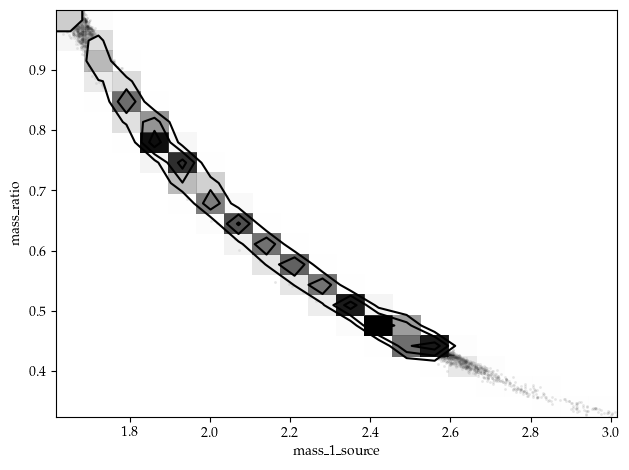

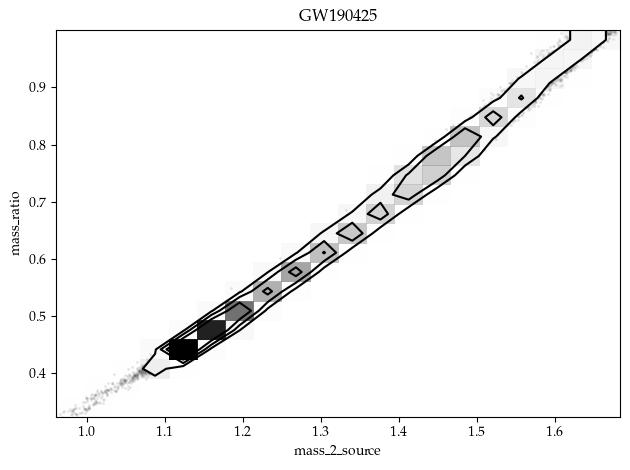

Correlation coefficient: -0.976
Correlation coefficient: 0.998


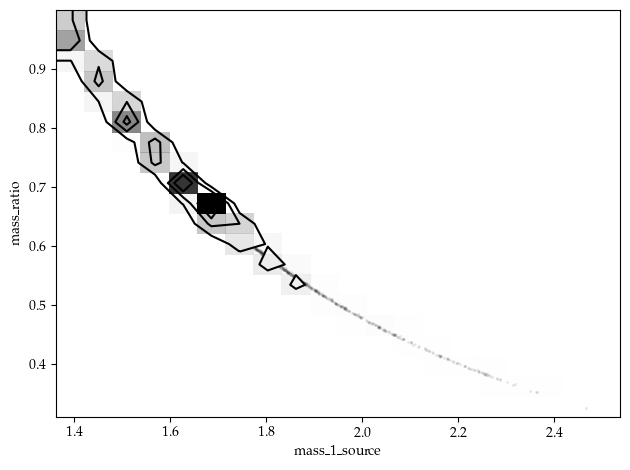

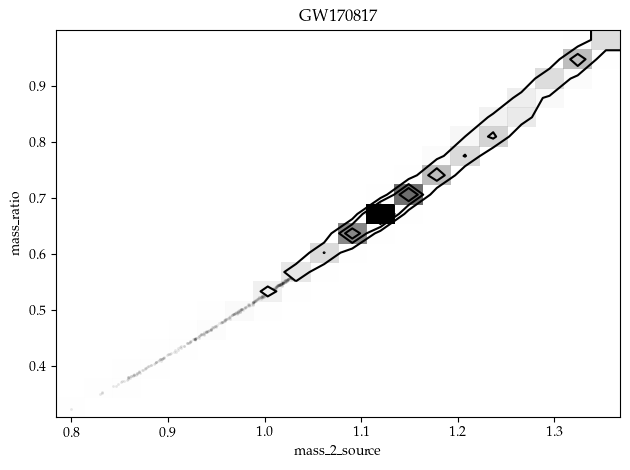

Correlation coefficient: -0.944
Correlation coefficient: 0.993


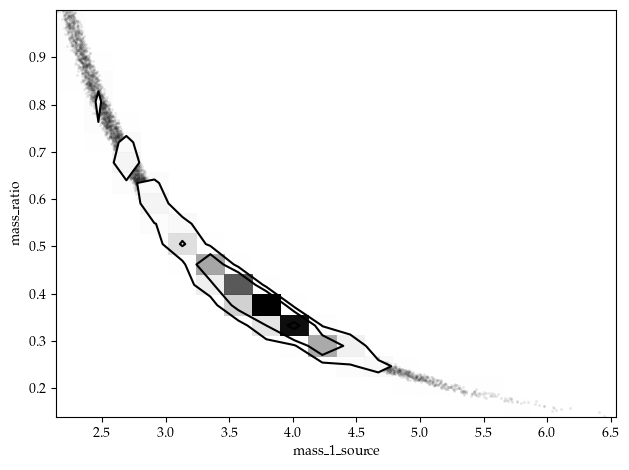

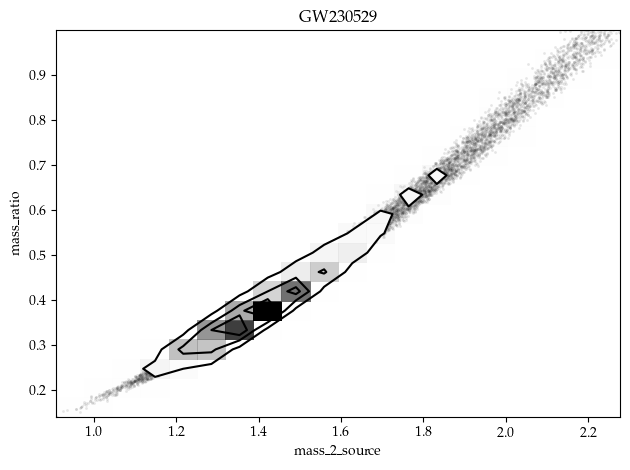

Correlation coefficient: -0.951
Correlation coefficient: 0.989


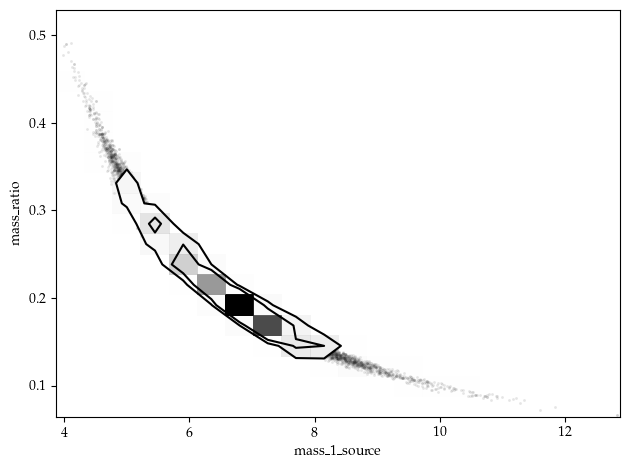

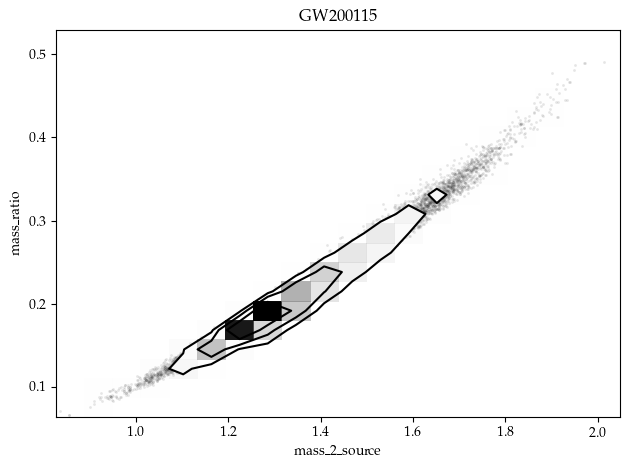

Correlation coefficient: -0.938
Correlation coefficient: 0.989


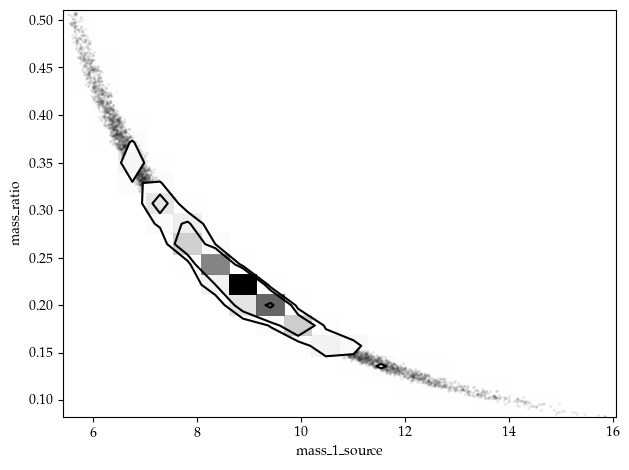

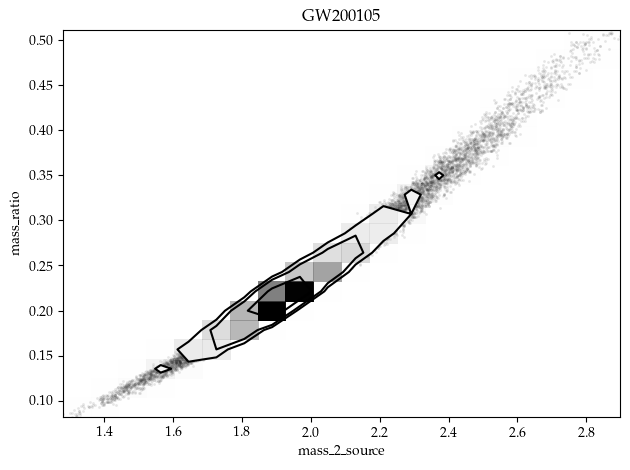

Correlation coefficient: -0.962
Correlation coefficient: 0.981


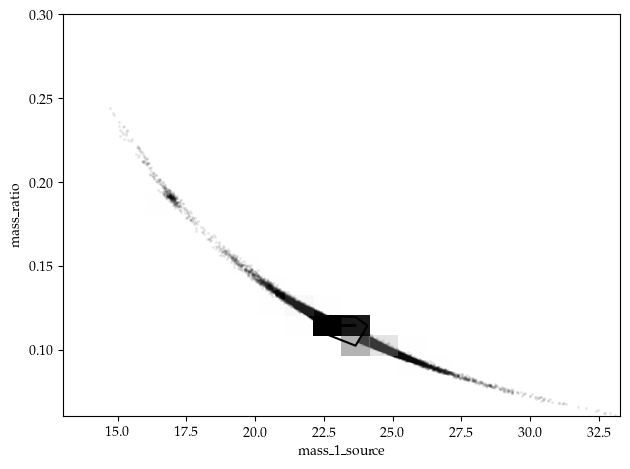

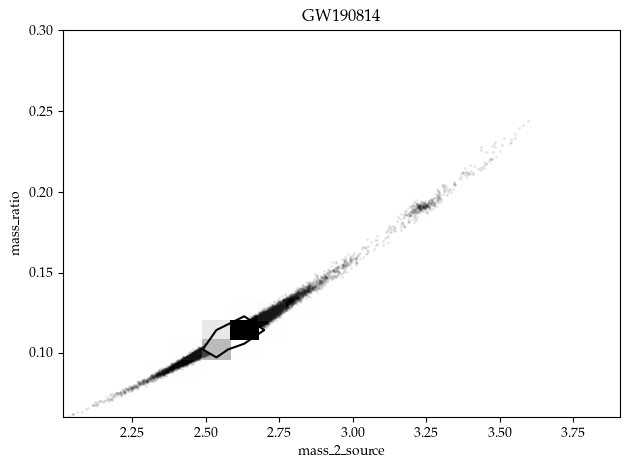

In [18]:
# Does the shape of the m1, m2 vs xeff distribution change between events? 
varXa = "mass_1_source"
varYb = "chi_eff"

for i in range(len(combined_lst)):
    plt.figure()
    corner_plot(combined_lst[i][varXa], combined_lst[i][varY])
    plt.xlabel(varXa)
    plt.ylabel(varY)
    plt.figure()
    corner_plot(combined_lst[i][varXb], combined_lst[i][varY])
    plt.title(names_list[i])
    plt.xlabel(varXb)
    plt.ylabel(varY)
    plt.show()

Mergers with at least 1 black hole, seem to have a straighter correlation between mass and effective spin. However, the tighter correlation does not always need to manifest itself in the BH. The tighter correlation may appear in the neutron star. 

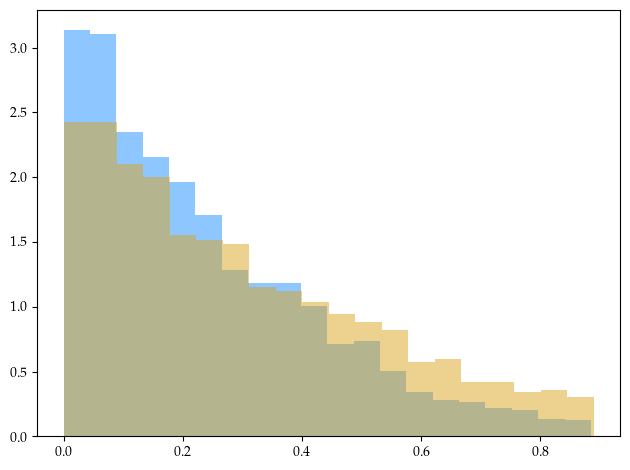

In [19]:
# Does p(x1) look different than p(x2) 
plt.figure()
plt.hist(combined["spin1"], bins=20, alpha=0.5, density=True)
plt.hist(combined["spin2"], bins=20, alpha=0.5, density=True)
plt.show()

The distribution of spin1 and spin2 are similar.

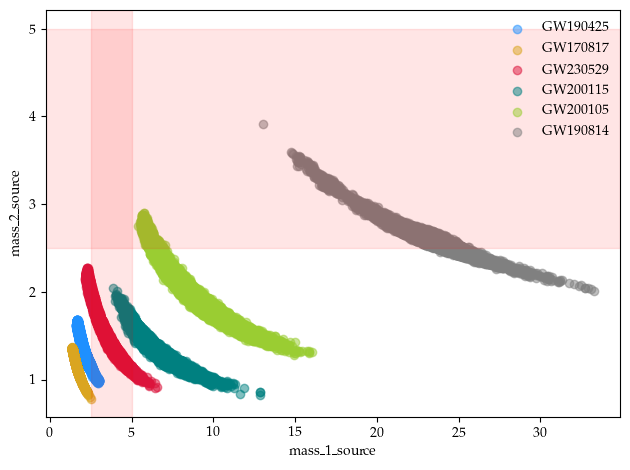

In [20]:
# compute mean masses and plot on scatter plot
plt.figure()

for i in range(len(combined_lst)):
    event = combined_lst[i]
    plt.scatter(event["mass_1_source"], event["mass_2_source"], alpha=0.5, label=names_list[i])
plt.axvspan(2.5, 5, color='red', alpha=0.1)
plt.axhspan(2.5, 5, color='red', alpha=0.1)
plt.xlabel("mass_1_source")
plt.ylabel("mass_2_source")
plt.legend()
plt.show()

(array([1115.,  806.,  657.,  441.,  392.,  259.,  152.,   97.,   75.,
          47.]),
 array([1.39299340e-05, 8.84735788e-02, 1.76933228e-01, 2.65392877e-01,
        3.53852526e-01, 4.42312174e-01, 5.30771823e-01, 6.19231472e-01,
        7.07691121e-01, 7.96150770e-01, 8.84610419e-01]),
 <BarContainer object of 10 artists>)

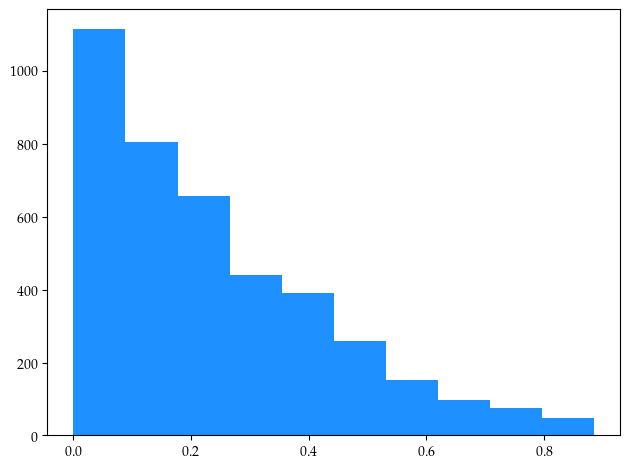

In [21]:
plt.hist(GW170817["spin1"])
# Low spin should have lower correlaitons, priors should restrict the range 

Text(0, 0.5, 'mass_2_source')

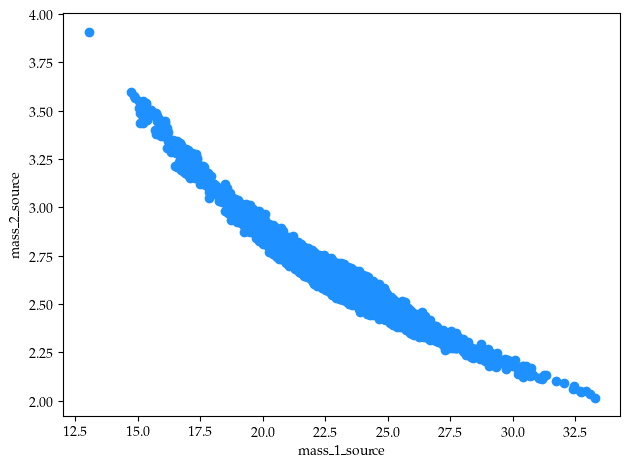

In [27]:
plt.plot(GW170817["mass_1_source"], GW170817["mass_2_source"], "o")
plt.xlabel("mass_1_source")
plt.ylabel("mass_2_source")

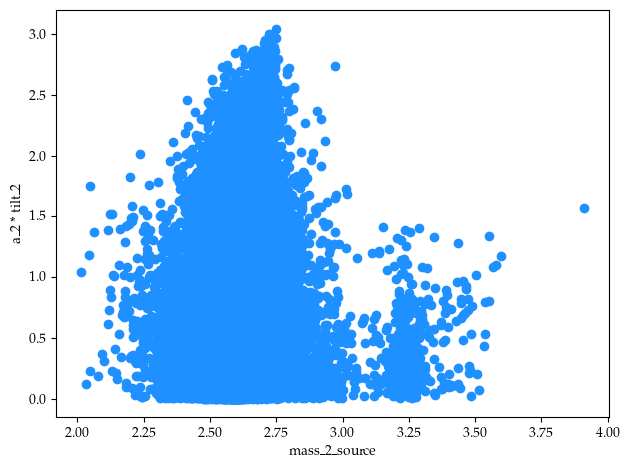

In [23]:
plt.figure()
plt.scatter(GW190814["mass_2_source"], GW190814["a_2"]*GW190814["tilt_2"])
plt.xlabel("mass_2_source")
plt.ylabel("a_2 * tilt_2")
plt.show()

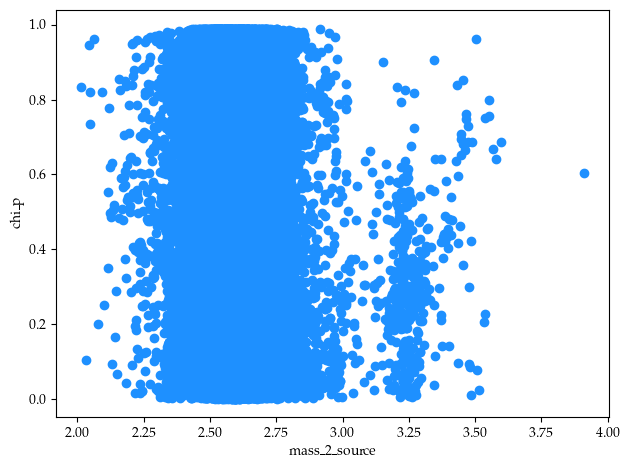

In [28]:
plt.figure()
plt.scatter(GW190814["mass_2_source"], GW190814["a_2"])
plt.xlabel("mass_2_source")
plt.ylabel("chi_p")
plt.show()